In [20]:
import torch
import dataLoader
from model import CNN_LSTM_0_WTB
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib

In [35]:
dl = 0  ## 时延
ts = 26 ## 滑窗宽度
lb = 1  ## 步长
modelPath = "./checkpoints/WTB_icing/res_26_11/CNN-LSTM-2.t7"  ## 模型所在地址
origTestRoot = "./data/WTB_icing/orig/test"
testRoot = "./data/WTB_icing/test"
saveRoot = "./results/WTB_icing/res_26_1_5/"

In [3]:
##### 加载测试数据
X_test, y_test, mask_test = dataLoader.window_process2(origTestRoot, testRoot, dl, ts, lb)
X_test = np.array(X_test)
y_test = np.array(y_test)
mask_test = np.array(mask_test)
y_test = to_categorical(y_test, 2)

# 对数据进行随机打乱
permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation, :, :, :]
y_test = y_test[permutation, :]
mask_test = mask_test[permutation, :, :]

inputs = torch.Tensor(X_test)
target = torch.Tensor(y_test)
mask = torch.Tensor(mask_test)  

In [36]:
##### 加载模型
net = CNN_LSTM_0_WTB.CNN_LSTM(ts)
checkpoint = torch.load(modelPath)
print(checkpoint['best_test_acc'])
# net.load_state_dict(checkpoint['net'])

86.31219888009915


In [5]:
##### 运行模型
net.eval()
with torch.no_grad():
    x1_atten, atten1, x1, x2, x3, x4, x = net(inputs, mask)

In [6]:
##### 计算测试准确率
total = x.size(0)
_, predicted = torch.max(x.data, 1)
_, trueValue = torch.max(target.data, 1)
# correct = predicted.eq(trueValue.data).sum()
# acc = int(correct.data) / total
# np.savetxt(saveRoot + "acc.txt", [acc])

In [7]:
##### 获得混淆矩阵
cm = confusion_matrix(trueValue.numpy(), predicted.numpy())

In [8]:
##### 定义图片上的标签
attack_types = ['Normal', 'Icing']

In [9]:
##### 定义图片上的字体
font = {'family': 'Times New Roman',
         'style': 'normal',
         'weight': 'bold',
        #'color':  'darkred', 
        'size': 20,
        }

In [10]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes, saveRoot, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if 0 < cm[i, j] < 1:
            fmt = '.4f' if normalize else 'd'
        else:
            fmt = ".0f" if normalize else "d"
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True categories')
    plt.xlabel('Predicted categories')
    plt.savefig(saveRoot)

Normalized confusion matrix


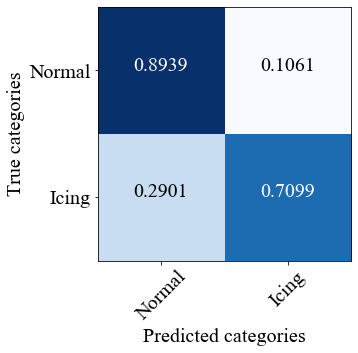

In [11]:
matplotlib.rc('font', **font)
plt.figure(figsize=(6, 5))
plot_confusion_matrix(cm, classes=attack_types, saveRoot=saveRoot + "cm.svg", normalize=True)